In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools 
import random
import sys

GraphWithComponents is a cluster graph $M \in \mathcal{M_{\leq 2}}$  that has two or less components of connectivity

In [26]:
class GraphWithComponents:
    def __init__(self, G: nx.Graph, firstComponent: nx.Graph, secondComponent: nx.Graph) -> nx.Graph:
        self.G = G
        self.firstComponent = firstComponent
        self.secondComponent = secondComponent
        pass

Distance between graphs $G_1 = (V, E_1), G_2 = (V, E_2)$ is a function

$p(G_1, G_2) = |E_1 \Delta E_2| = |E_1 \setminus E_2| + |E_2 \setminus E_1|$

In [27]:
def distance(G: nx.Graph, H: nx.Graph) -> int:
    Gedges = G.edges
    Hedges = H.edges
    
    for edge in Gedges:
        if edge[0] > edge[1]:
            edge = (edge[1], edge[0])
            
    for edge in Hedges:
        if edge[0] > edge[1]:
            edge = (edge[1], edge[0])
            
    return len(set(Gedges) - set(Hedges)) + len(set(Hedges) - set(Gedges))


$A_v^+$ is amount of nodes $u \in A$ such that $(u, v) \in E$   

In [28]:
def A_plus(G: nx.Graph, A: list[int], v: int):
    res = []
    for u in A:
        if G.has_edge(v, u) and v != u:
            res.append((v, u))
    return len(res)

$A_v^-$ is amount of nodes $u \in A$ such that $(u, v) \notin E$   

In [29]:
def A_minus(G: nx.Graph, A: list[int], v: int):
    res = []
    for u in A:
        if not G.has_edge(v, u) and v != u:
            res.append((v, u))
    return len(res)

BBC Algorithm is a polinomial algorithm for finding $\mathcal{M_{\leq 2}}(V)$ cluster graph

In: Graph $G = (V, E)$

Out: Cluster graph $M \in \mathcal{M_{\leq 2}}$

In [30]:
def BBC(graph: nx.Graph) -> GraphWithComponents:
    M = None 
    p = sys.maxsize
    
    for node in graph.nodes:
        temp = nx.Graph()
        temp.add_nodes_from(graph)

        N_g = list(graph.neighbors(node))
        N_g.append(node)

        not_N_g = list(set(graph.nodes) - set(N_g))

        v1 = list(itertools.combinations(N_g, 2))
        v2 = list(itertools.combinations(not_N_g, 2))

        temp.add_edges_from(v1)
        temp.add_edges_from(v2)

        if(distance(temp, graph) < p):
            p = distance(temp, graph)
            
            firstComponent = nx.Graph()
            firstComponent.add_edges_from(v1)

            secondComponent = nx.Graph()
            secondComponent.add_edges_from(v2)
            
            M = GraphWithComponents(temp, firstComponent, secondComponent)

    return M

Local Search Algorithm

In: Cluster Graph $M = M(X, Y) \in \mathcal{M_{\leq 2}}$

Out: Cluster Graph $\overline{M} = M(\overline{X}, \overline{Y}) \in \mathcal{M_{\leq 2}}$

In [31]:
def LS(graphWithComponents: GraphWithComponents) -> GraphWithComponents:
    v_0 = None 
    u_0 = None
    sigma_v_0 = -sys.maxsize
    sigma_u_0 = -sys.maxsize
    
    for v in graphWithComponents.firstComponent.nodes:
        
        X_plus_v = A_plus(graphWithComponents.G, graphWithComponents.firstComponent.nodes, v)
        X_minus_v = A_minus(graphWithComponents.G, graphWithComponents.firstComponent.nodes, v)
        Y_plus_v = A_plus(graphWithComponents.G, graphWithComponents.secondComponent.nodes, v)
        Y_minus_v = A_minus(graphWithComponents.G, graphWithComponents.secondComponent.nodes, v)
        
        temp_sigma_v = X_minus_v - X_plus_v + Y_plus_v - Y_minus_v
        
        if temp_sigma_v > sigma_v_0:
            sigma_v_0 = temp_sigma_v
            v_0 = v
            
    for u in graphWithComponents.secondComponent.nodes:
        X_plus_u = A_plus(graphWithComponents.G, graphWithComponents.firstComponent.nodes, u)
        X_minus_u = A_minus(graphWithComponents.G, graphWithComponents.firstComponent.nodes, u)
        Y_plus_u = A_plus(graphWithComponents.G, graphWithComponents.secondComponent.nodes, u)
        Y_minus_u = A_minus(graphWithComponents.G, graphWithComponents.secondComponent.nodes, u)
        
        temp_sigma_u = Y_minus_u - Y_plus_u + X_plus_u - X_minus_u
        
        if(temp_sigma_u > sigma_u_0):
            sigma_u_0 = temp_sigma_u
            u_0 = u
    
    if sigma_v_0 <= 0 and sigma_u_0 <= 0:
        return graphWithComponents
    
    if sigma_v_0 >= sigma_u_0:
        newFirstComponent = graphWithComponents.firstComponent
        newFirstComponent.remove_node(v_0)
        
        newSecondComponent = graphWithComponents.secondComponent
        newSecondComponent.add_node(v_0)
        for node in newSecondComponent.node:
            if node != v_0:
                newSecondComponent.add_edge(v_0, node)
        
        newGraphWithComponents = GraphWithComponents(graphWithComponents.G, newFirstComponent, newSecondComponent)

        return LS(newGraphWithComponents)
        
    if sigma_v_0 < sigma_u_0:
        newFirstComponent = graphWithComponents.firstComponent
        newFirstComponent.add_node(u_0)
        for node in newFirstComponent.node:
            if node != u_0:
                newSecondComponent.add_edge(u_0, node)
        
        newSecondComponent = graphWithComponents.secondComponent
        newSecondComponent.remove_node(u_0)
        
        newGraphWithComponents = GraphWithComponents(graphWithComponents.G, newFirstComponent, newSecondComponent)
        
        return LS(newGraphWithComponents) 

CSW Algorithm is a polinomial algorithm for finding $\mathcal{M_{\leq 2}}(V)$ cluster graph

In: Graph $G = (V, E)$

Out: Cluster graph $M \in \mathcal{M_{\leq 2}}$

In [32]:
def CSW(graph: nx.Graph) -> GraphWithComponents:
    M = None
    p = sys.maxsize
    
    for node in graph.nodes:
        temp = nx.Graph()
        temp.add_nodes_from(graph)

        N_g = list(graph.neighbors(node))
        N_g.append(node)

        not_N_g = list(set(graph.nodes) - set(N_g))

        v1 = list(itertools.combinations(N_g, 2))
        v2 = list(itertools.combinations(not_N_g, 2))

        temp.add_edges_from(v1)
        temp.add_edges_from(v2)
        
        firstComponent = nx.Graph()
        firstComponent.add_edges_from(v1)

        secondComponent = nx.Graph()
        secondComponent.add_edges_from(v2)
        
        graphWithComponents = GraphWithComponents(temp, firstComponent, secondComponent)
        tempM = LS(graphWithComponents)
        
        if(distance(tempM.G, graph) < p):
            M = tempM
            
    return M

ThreeCluseterGraph is a cluster graph $M \in \mathcal{M_{\leq 3}}$  that has three or less components of connectivity 

In [33]:
class ThreeClusterGraph():
    def __init__(self, G: nx.Graph, firstComponent: nx.Graph, secondComponent: nx.Graph, thirdComponent: nx.Graph) -> nx.Graph:
        self.G = G
        self.firstComponent = firstComponent
        self.secondComponent = secondComponent
        self.thirdComponent = thirdComponent
        pass
    

$A_1$ Algorithm

In: Graph $G=(V, E), |V|=n$

Out: Cluster graph $M_1\in\mathcal{M_{\leq 3}}(V)$

In [34]:
def A1(graph: nx.Graph, n: int) -> ThreeClusterGraph:
    if n <=2:
        return ThreeClusterGraph(graph.copy, nx.Graph(), nx.Graph(), nx.Graph())
    
    M_1 = None
    p = sys.maxsize
    
    for w in graph.nodes:
        V_1 = set(graph.neighbors(w))
        V_1.add(w)
        M_w = None 
        
        if(V_1 == set(graph.nodes)):
            M_w = nx.complete_graph(n)
            
            if(distance(M_w, graph) < p):
                M_1 = ThreeClusterGraph(M_w, M_w, nx.Graph(), nx.Graph())
        else:
            G_1 = graph.copy()
            G_1.remove_nodes_from(V_1)
            M = CSW(G_1)
            
            complete_V_1 = list(itertools.combinations(V_1, 2))
            firstComponent = nx.Graph()
            firstComponent.add_edges_from(complete_V_1)
            secondComponent = M.firstComponent
            thirdComponent = M.secondComponent
            M = M.G
            M.add_edges_from(complete_V_1)
            
            M_w = ThreeClusterGraph(M, firstComponent, secondComponent, thirdComponent)
        
        if(distance(M_w.G, graph) < p):
                M_1 = M_w
        
    return M_1

In [35]:
def A2(graph: nx.Graph, n: int) -> ThreeClusterGraph:
    p = distance(graph, nx.complete_graph(n))
    M_2 = ThreeClusterGraph(nx.complete_graph(n), nx.complete_graph(n), nx.Graph(), nx.Graph())
    for u_v_pair in itertools.combinations(graph.nodes, 2):
        V_1 = set.union(set([u_v_pair[0]]), set(graph.neighbors(u_v_pair[0])) - set([u_v_pair[1]]))
        G_1 = graph.copy()
        G_1.remove_nodes_from(V_1)
        V_2 = set.union(set([u_v_pair[1]]), set(G_1.neighbors(u_v_pair[1])))
        V_3 = set(graph.nodes) - set.union(V_1, V_2)
        
        firstComponent = nx.Graph()
        firstComponent.add_edges_from(list(itertools.combinations(V_1, 2)))
        
        secondComponent = nx.Graph()
        secondComponent.add_edges_from(list(itertools.combinations(V_2, 2)))
        
        thirdComponent = nx.Graph()
        thirdComponent.add_edges_from(list(itertools.combinations(V_3, 2)))
        
        resultGraph = nx.Graph()
        resultGraph.add_edges_from(firstComponent.edges)
        resultGraph.add_edges_from(secondComponent.edges)
        resultGraph.add_edges_from(thirdComponent.edges)
        
        tempM_2 = ThreeClusterGraph(resultGraph, firstComponent, secondComponent, thirdComponent)
        
        if(distance(graph, tempM_2.G) < p):
            M_2 = tempM_2
            
    return M_2

In [36]:
def BruteForce(graph: nx.Graph) -> ThreeClusterGraph:
    pass

# Tests 

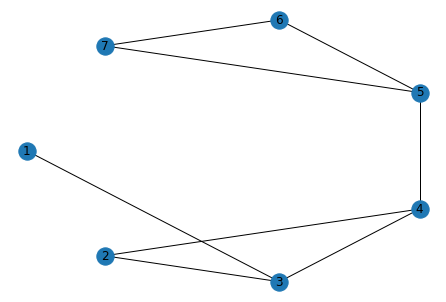

In [37]:
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5, 6, 7])
G.add_edges_from([(1, 3), (2, 3), (2, 4), (3, 4), (4, 5), (5, 6), (5, 7), (6, 7)])
nx.draw_shell(G, with_labels=True)

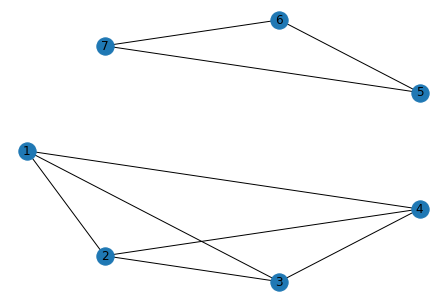

In [38]:
M = BBC(G)
nx.draw_shell(M.G, with_labels=True)

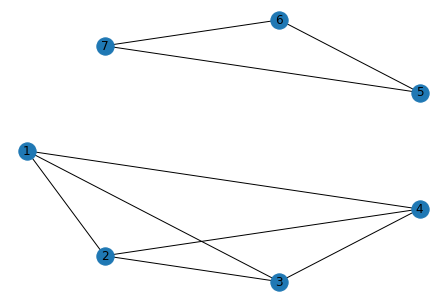

In [39]:
M = CSW(G)
nx.draw_shell(M.G, with_labels=True)

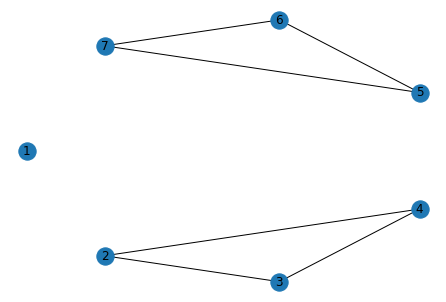

In [40]:
M = A1(G, len(G.nodes))
nx.draw_shell(M.G, with_labels=True)

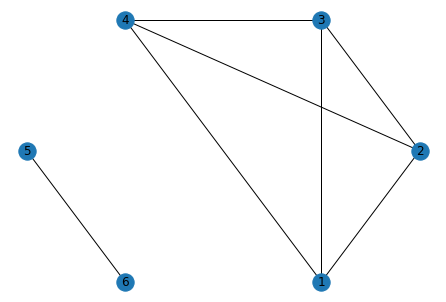

In [41]:
M = A2(G, len(G.nodes))
nx.draw_shell(M.G, with_labels=True)

# Comparison

In [42]:
def RandomGraph(n: int) -> nx.Graph:
    G = nx.Graph()
    G.add_nodes_from(list(np.arange(n)))
    for edge in itertools.combinations(G.nodes, 2):
        if random.random() <= 0.5:
            G.add_edge(edge[0], edge[1])
    return G

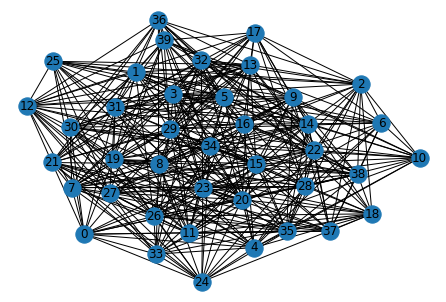

In [43]:
G = RandomGraph(40)
nx.draw(G, with_labels=True)

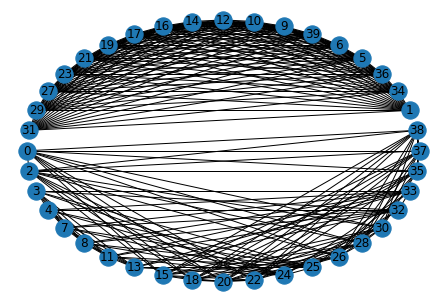

In [44]:
M_1 = A1(G, len(G.nodes))
nx.draw_shell(M_1.G, with_labels=True)

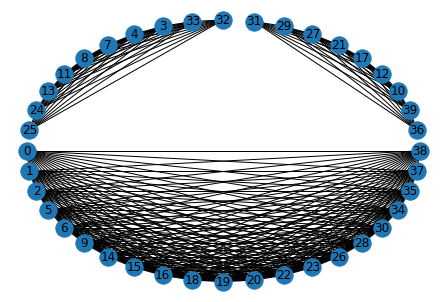

In [45]:
M_2 = A2(G, len(G.nodes))
nx.draw_shell(M_2.G, with_labels=True)

In [46]:
print("p on A_1: ", distance(G, M_1.G))
print("p on A_2: ", distance(G, M_2.G))

p on A_1:  403
p on A_2:  388


In [47]:
x = np.arange(40) + 25

A_1_y = np.zeros_like(x)
A_2_y = np.zeros_like(x)
i = 0
for v in x:
    print("iter", i)
    G = RandomGraph(v)
    
    A_1 = A1(G, len(G.nodes))
    A_2 = A2(G, len(G.nodes))
    
    A_1_y[i] = distance(G, A_1.G)
    A_2_y[i] = distance(G, A_2.G)
    
    i = i + 1
    

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39


<AxesSubplot:>

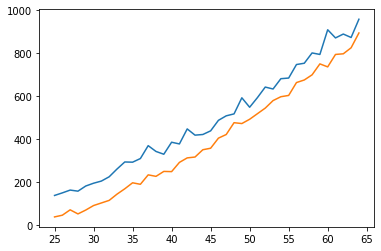

In [50]:
import seaborn as sns

sns.lineplot(x = x, y = A_1_y)
sns.lineplot(x = x, y = A_2_y)